In [6]:
#STEP -1
#Downloading the CIFAR-10 Dataset

from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile
import numpy as np

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num = 1, block_size = 1, total_size = None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit = 'B', unit_scale = True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 
                        'cifar-10-python.tar.gz',
                        pbar.hook)
            
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz', mode="r:gz") as tar:
        tar.extractall()
        tar.close()
            
tests.test_folder_path(cifar10_dataset_folder_path)


print("All modules and CIFAR-10 dataset imported successfully")
            
    

All files found!
All modules and CIFAR-10 dataset imported successfully



Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 25:
Image - Min Value: 0 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


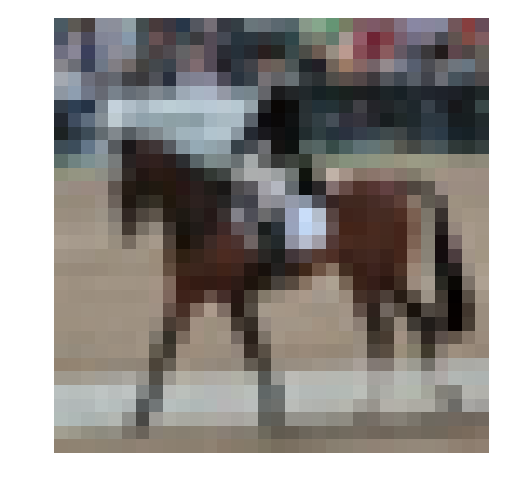

In [7]:
#STEP-2 Visualizing the dataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

batch_id=5
sample_id=25
helper.display_stats(cifar10_dataset_folder_path,batch_id,sample_id)


In [8]:
#PREPROCESSING THE DATASET.
#Data Normalization.
#Implementing a function to normalize the dataset.

def normalize(x):
    b=255
    a=0
                             
    return (x - a) / (b - a)

tests.test_normalize(normalize)

Tests Passed


In [9]:
#One-Hot_Encoding
def one_hot_encode(x):
    y = np.zeros((len(x),10))
    for i in range(len(x)):
        y[i,x[i]] = 1
    return y

tests.test_one_hot_encode(one_hot_encode)

Tests Passed


In [10]:
#Preprocess and save the training set.
helper.preprocess_and_save_data(cifar10_dataset_folder_path,normalize,one_hot_encode)

print("Applied normalisation to data and one_hot_encoding to labels")

Applied normalisation to data and one_hot_encoding to labels


In [11]:
#CHECK-POINT
#creating a check point so that we can load the preprocessed data from this point

import pickle
import problem_unittests as tests
import helper

valid_features,valid_labels = pickle.load(open('preprocess_validation.p', mode ='rb'))

print("Check-point has been created ")

Check-point has been created 


In [12]:
import tensorflow as tf

#Building the network
#Feed input to the network
#def neural_net_image_input(image_shape) which return image info to the network
#def neural_net_label_input(n_classes) which return label infor to the network
#def neural_net_keep_prob_input() which set the keep_probability value during dropout

def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32,[None]+list(image_shape),"x")
def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32,[None,n_classes],"y")
def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32,None,"keep_prob")

tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


In [13]:
#Convolution and Max-pool layer
def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
    dimension = x_tensor.get_shape().as_list()
    shape = list(conv_ksize+(dimension[-1],)+(conv_num_outputs,))
    
    #defining wt and bias matrix
    filter_weights = tf.Variable(tf.truncated_normal(shape,0,0.1))
    filter_bias = tf.Variable(tf.zeros(conv_num_outputs))
    
    #defining the convolution_layer
    padding = 'SAME'
    conv_layer = tf.nn.conv2d(x_tensor,filter_weights,list((1,)+conv_strides+(1,)),padding)
    conv_layer = tf.nn.bias_add(conv_layer,filter_bias)
    conv_layer = tf.nn.relu(conv_layer)
    
    #defining the max_pool_layer
    conv_layer = tf.nn.max_pool(conv_layer,ksize=[1]+list(pool_ksize)+[1],strides=[1]+list(pool_strides)+[1],padding='SAME')
    
    return conv_layer

tests.test_con_pool(conv2d_maxpool)

Tests Passed


In [14]:
from numpy import prod
def flatten(x_tensor):
    dimension = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor,[-1,prod(dimension[1:])])
    
tests.test_flatten(flatten)

Tests Passed


In [15]:
def fully_conn(x_tensor,num_outputs):
    dimension = x_tensor.get_shape().as_list()
    shape = list((dimension[-1],)+(num_outputs,))
    
    weights = tf.Variable(tf.truncated_normal(shape,num_outputs))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    return tf.nn.relu(tf.add(tf.matmul(x_tensor,weights),bias))


tests.test_fully_conn(fully_conn)

Tests Passed


In [16]:
def output(x_tensor,num_outputs):
    dimension = x_tensor.get_shape().as_list()
    shape = list((dimension[-1],) + (num_outputs,))
    
    weights = tf.Variable(tf.truncated_normal(shape,num_outputs))
    bias = tf.Variable(tf.zeros(num_outputs))
    
    return tf.add(tf.matmul(x_tensor,weights),bias)

tests.test_output(output)

Tests Passed


In [17]:
#BUILDING THE MODEL
#A good convolution layer shouldhavef
#1.Convolution_layer
#2.Max_pool_layer
#3.Fully_connected_layer

def conv_net(x, keep_prob):
    #Building convolution layer & Max_pool layer
    #model = conv2d_maxpool(x,conv_num_outputs=20,conv_ksize=(2,2),conv_strides=(1,1),pool_ksize=(2,2),pool_strides=(1,1))
    model = conv2d_maxpool(x,conv_num_outputs=18,conv_ksize=(4,4),conv_strides=(1,1),pool_ksize=(8,8),pool_strides=(1,1))

    #Applying flatten func to model to reshape
    model = flatten(model)
    #Building a fully_connected model
    #model = fully_conn(model,300)
    model = fully_conn(model,360)
    #Creating the output of the model
    model = output(model,10)
    return model


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


In [18]:
#Training the neural network

def train_neural_network(session,optimizer,keep_probability,feature_batch,label_batch):
    session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})
    
tests.test_train_nn(train_neural_network)

Tests Passed


In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    # pass
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,
                valid_acc))

In [ ]:
epochs = 100
batch_size = 512
keep_probability = 0.3

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 10285091.0000 Validation Accuracy: 0.094600
Epoch  2, CIFAR-10 Batch 1:  Loss: 1087103.6250 Validation Accuracy: 0.094600
Epoch  3, CIFAR-10 Batch 1:  Loss: 324556.9062 Validation Accuracy: 0.094600
Epoch  4, CIFAR-10 Batch 1:  Loss: 146628.9531 Validation Accuracy: 0.093200
Epoch  5, CIFAR-10 Batch 1:  Loss: 88281.5234 Validation Accuracy: 0.088000


In [ ]:
#FULLY_TRAIN_THE_MODEL
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()
print("running")